In [1]:
!pip install xgboost

In [2]:
# Importing Necessary Modules
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt

import imblearn
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the Dataset
data = pd.read_csv("train.csv")

In [4]:
data.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


In [5]:
data.shape

(45211, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45211 non-null  int64 
 1   job             45211 non-null  object
 2   marital         45211 non-null  object
 3   education_qual  45211 non-null  object
 4   call_type       45211 non-null  object
 5   day             45211 non-null  int64 
 6   mon             45211 non-null  object
 7   dur             45211 non-null  int64 
 8   num_calls       45211 non-null  int64 
 9   prev_outcome    45211 non-null  object
 10  y               45211 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.8+ MB


In [7]:
data.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y'],
      dtype='object')

In [8]:
# Unique values of each columns
for i in data.columns:
  print(i)
  print(data[i].unique())

age
[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital
['married' 'single' 'divorced']
education_qual
['tertiary' 'secondary' 'unknown' 'primary']
call_type
['unknown' 'cellular' 'telephone']
day
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
mon
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
dur
[ 261  151   76 ... 1298 1246 1556]
num_calls
[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]
prev_outcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


In [9]:
# Identifying integer columns
number = data.select_dtypes(include=[np.number])
number.columns

Index(['age', 'day', 'dur', 'num_calls'], dtype='object')

In [10]:
# Identyfing category columns
string = data.select_dtypes(include=['object']).columns
string

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome',
       'y'],
      dtype='object')

In [11]:
# Checking for correct datatypes
data.dtypes

,0
age,int64
job,object
marital,object
education_qual,object
call_type,object
day,int64
mon,object
dur,int64
num_calls,int64
prev_outcome,object


In [12]:
data.job.value_counts()

,count
job,
blue-collar,9732
management,9458
technician,7597
admin.,5171
services,4154
retired,2264
self-employed,1579
entrepreneur,1487
unemployed,1303


In [13]:
# Replacing the unknown values
data.job = data.job.str.replace("unknown","blue-collar")

In [14]:
data.job.value_counts()

,count
job,
blue-collar,10020
management,9458
technician,7597
admin.,5171
services,4154
retired,2264
self-employed,1579
entrepreneur,1487
unemployed,1303


In [15]:
data.education_qual.value_counts()

,count
education_qual,
secondary,23202
tertiary,13301
primary,6851
unknown,1857


In [16]:
data.education_qual = data.education_qual.str.replace("unknown","secondary")

In [17]:
data.education_qual.value_counts()

,count
education_qual,
secondary,25059
tertiary,13301
primary,6851


In [18]:
data.call_type.value_counts()

,count
call_type,
cellular,29285
unknown,13020
telephone,2906


In [19]:
# Converting the target value from 'str' to 'int'
# Count of values to Target variable columns
data['y'].value_counts()

,count
y,
no,39922
yes,5289


In [20]:
# Find the sum of y variable
d = pd.Series({'no': 39922, 'yes': 5289})
total = d.sum()

print(total)

# Finding the percentage for target variable (No)
no = ((39922)/(total))*100
print(no)

# Finding the percentage for target variable (Yes)
yes = ((5289)/(total))*100
print(yes)

45211
88.30151954170445
11.698480458295547


In [21]:
# Converting the values of 'y' to numerical values
data['y'] = data['y'].map({'yes':1,'no':0})

In [22]:
data

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,0
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,secondary,unknown,5,may,92,1,unknown,0
4,33,blue-collar,single,secondary,unknown,5,may,198,1,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,1
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,1
45208,72,retired,married,secondary,cellular,17,nov,1127,5,success,1
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,0


In [23]:
# Cleaning the data
# Checking for missing value
data.isnull().sum()

,0
age,0
job,0
marital,0
education_qual,0
call_type,0
day,0
mon,0
dur,0
num_calls,0
prev_outcome,0


In [24]:
data = data.dropna()

In [25]:
duplicates = data[data.duplicated()]
duplicates

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
6893,34,services,married,secondary,unknown,28,may,124,1,unknown,0
8138,29,admin.,single,secondary,unknown,2,jun,121,4,unknown,0
11630,39,blue-collar,married,primary,unknown,19,jun,112,4,unknown,0
13400,36,blue-collar,married,secondary,cellular,9,jul,183,1,unknown,0
19826,36,management,married,tertiary,cellular,8,aug,75,2,unknown,0
19854,32,technician,single,tertiary,cellular,8,aug,31,2,unknown,0


In [26]:
# Checking for duplicates in data
data.duplicated().sum()

6

In [27]:
# There are 6 duplicates in the data, Removing the duplicates
data = data.drop_duplicates()
data.duplicated().sum()

0

In [28]:
data.shape

(45205, 11)

In [29]:
data.describe()

,age,day,dur,num_calls,y
count,45205.000000,45205.00000,45205.000000,45205.000000,45205.000000
mean,40.937087,15.80688,258.183055,2.763898,0.117000
std,10.619130,8.32234,257.538504,3.098189,0.321424
min,18.000000,1.00000,0.000000,1.000000,0.000000
25%,33.000000,8.00000,103.000000,1.000000,0.000000
50%,39.000000,16.00000,180.000000,2.000000,0.000000
75%,48.000000,21.00000,319.000000,3.000000,0.000000
max,95.000000,31.00000,4918.000000,63.000000,1.000000


In [30]:
# Detecting Outliers
# Detecting outliers for 'AGE' column
iqr = data.age.quantile(0.75) - data.age.quantile(0.25)
print('Interquantile range is', iqr)
up_threshold = data.age.quantile(0.75) + (1.5*iqr)
low_threshold = data.age.quantile(0.25) - (1.5*iqr)
data.age =data.age.clip(up_threshold,low_threshold).astype('int64')

print('Upper threshold is', up_threshold)
print('Lower threshold is', low_threshold)

below = data[data['age'] < low_threshold]['age'].count()
above = data[data['age'] > up_threshold]['age'].count()

print('above outlier count is', above)
print('below outlier count is', below)

Interquantile range is 15.0
Upper threshold is 70.5
Lower threshold is 10.5
above outlier count is 0
below outlier count is 0


In [31]:
# Detecting outliers for 'DUR' column
iqr = data.dur.quantile(0.75) - data.dur.quantile(0.25)
print('Interquantile range is', iqr)
up_threshold = data.dur.quantile(0.75) + (1.5*iqr)
low_threshold = data.dur.quantile(0.25) - (1.5*iqr)
data.dur =data.dur.clip(up_threshold,low_threshold).astype('int64')

print('Upper threshold is', up_threshold)
print('Lower threshold is', low_threshold)

below = data[data['dur'] < low_threshold]['dur'].count()
above = data[data['dur'] > up_threshold]['dur'].count()

print('above outlier count is', above)
print('below outlier count is', below)

Interquantile range is 216.0
Upper threshold is 643.0
Lower threshold is -221.0
above outlier count is 0
below outlier count is 0


In [32]:
# Detecting outliers for 'NUM_CALLS' column
iqr = data.num_calls.quantile(0.75) - data.num_calls.quantile(0.25)
print('Interquantile range is', iqr)
up_threshold = data.num_calls.quantile(0.75) + (1.5*iqr)
low_threshold = data.num_calls.quantile(0.25) - (1.5*iqr)
data.num_calls =data.num_calls.clip(up_threshold,low_threshold).astype('int64')

print('Upper threshold is', up_threshold)
print('Lower threshold is', low_threshold)

below = data[data['num_calls'] < low_threshold]['num_calls'].count()
above = data[data['num_calls'] > up_threshold]['num_calls'].count()

print('above outlier count is', above)
print('below outlier count is', below)

Interquantile range is 2.0
Upper threshold is 6.0
Lower threshold is -2.0
above outlier count is 0
below outlier count is 0


In [33]:
data.num_calls.describe()

,num_calls
count,45205.000000
mean,2.392235
std,1.600152
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


In [34]:
data.describe()

,age,day,dur,num_calls,y
count,45205.000000,45205.00000,45205.00000,45205.000000,45205.000000
mean,40.863666,15.80688,234.95620,2.392235,0.117000
std,10.380009,8.32234,176.75476,1.600152,0.321424
min,18.000000,1.00000,0.00000,1.000000,0.000000
25%,33.000000,8.00000,103.00000,1.000000,0.000000
50%,39.000000,16.00000,180.00000,2.000000,0.000000
75%,48.000000,21.00000,319.00000,3.000000,0.000000
max,70.000000,31.00000,643.00000,6.000000,1.000000


In [35]:
data.dtypes

,0
age,int64
job,object
marital,object
education_qual,object
call_type,object
day,int64
mon,object
dur,int64
num_calls,int64
prev_outcome,object


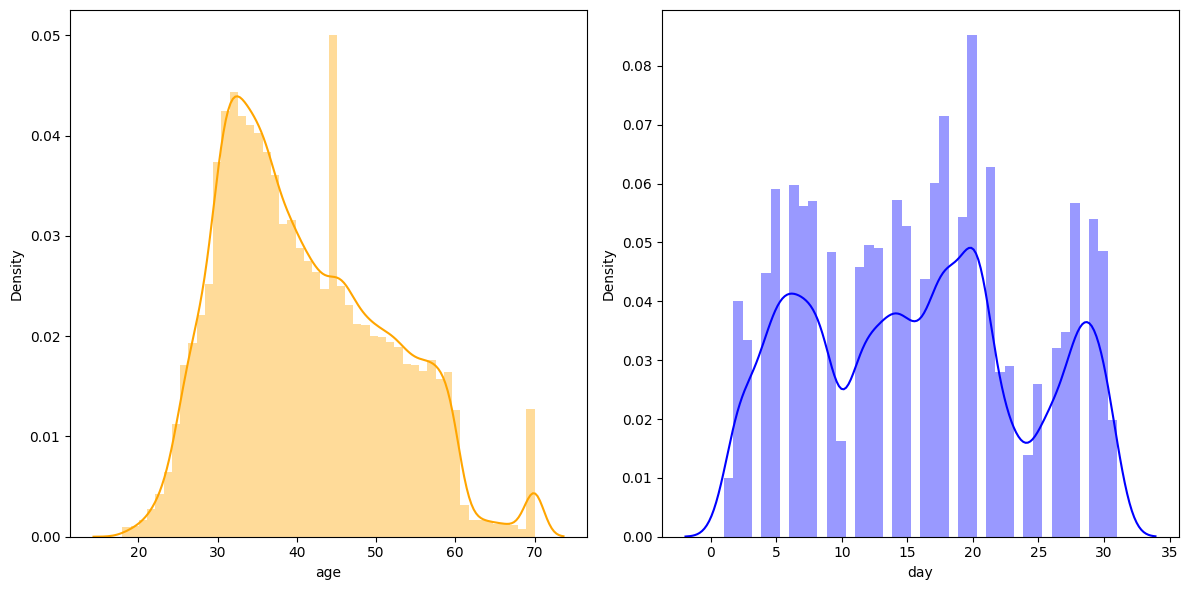

In [36]:
# Creating a plot to check the distribution for AGE and DAY
plt.figure(figsize=(12,6))                   # describing the size of the histogram
plt.subplot(1,2,1)                           # this creates a grid of 2 plots in a single row and gives which plot comes first
sns.distplot(data.age, color = 'orange')     # this pulls the data from age column and gives orange color histplot
plt.subplot(1,2,2)                           # this creates the 2nd of the same row
sns.distplot(data.day, color = 'blue')       # this pulls the data from the day column and gives blue color histplot
plt.tight_layout()                           # this adjusts the space between the two subplots to fit perfectly

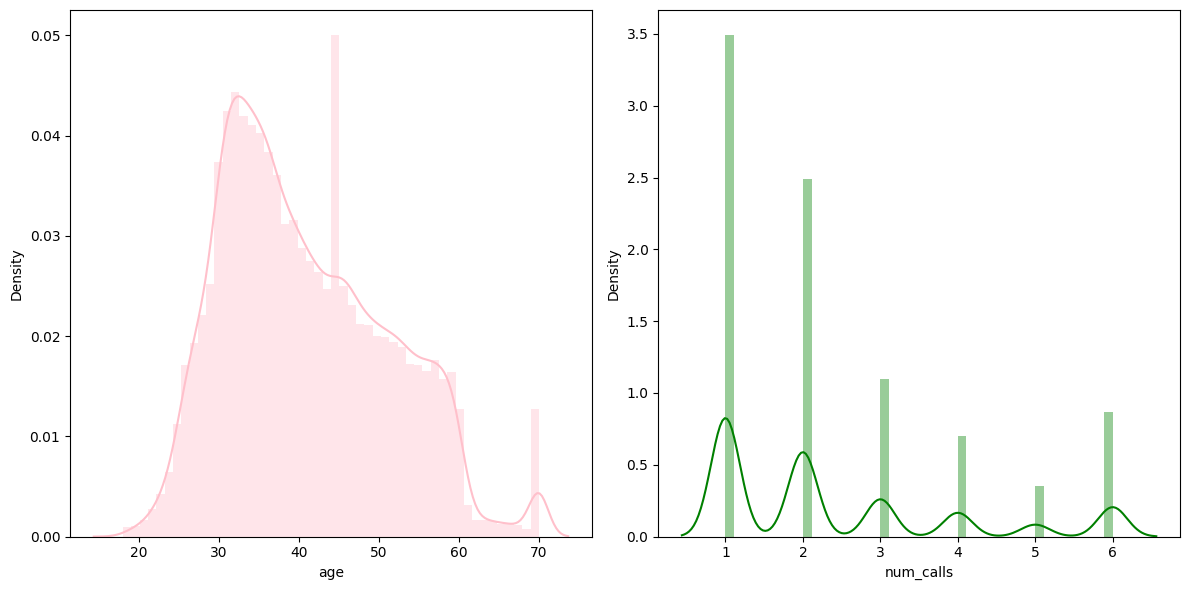

In [37]:
# Creating a plot to check the distribution for DUR and NUM_CALLS
plt.figure(figsize=(12,6))                       # describing the size of the histogram
plt.subplot(1,2,1)                               # this creates a grid of 2 plots in a single row and gives which plot comes first
sns.distplot(data.age, color = 'pink')           # this pulls the data from dur column and gives pink color histplot
plt.subplot(1,2,2)                               # this creates the 2nd plot of the same row
sns.distplot(data.num_calls, color = 'green')    # this pulls the data from num_calls column and gives green color histplot
plt.tight_layout()                               # this adjusts the space between the two subplots to fit perfectly

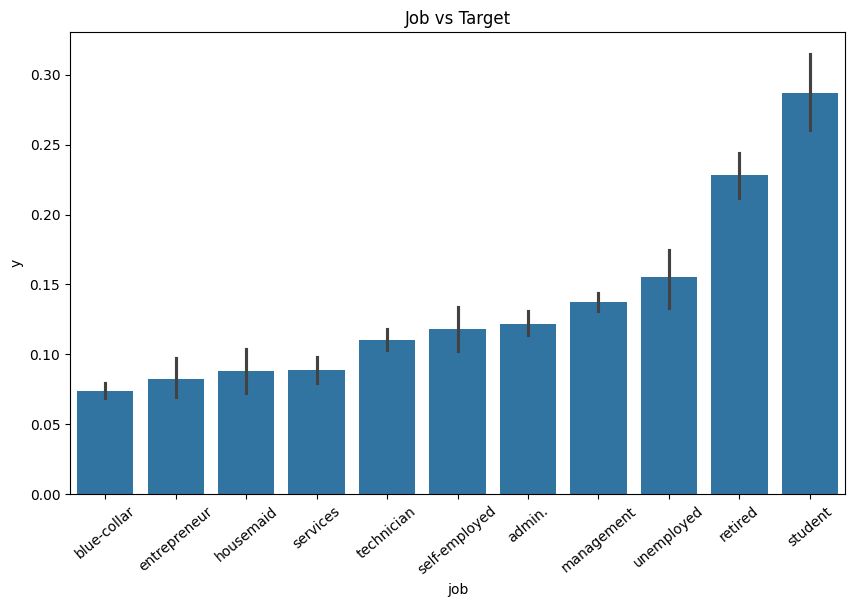

In [38]:
# Feature VS Target
# JOB
plt.figure(figsize=(10,6))
sns.barplot(x='job',y='y',data=data,order=data.groupby('job')['y'].mean().reset_index().sort_values('y')['job'])
plt.xticks(rotation=40)
plt.title('Job vs Target')
plt.show()

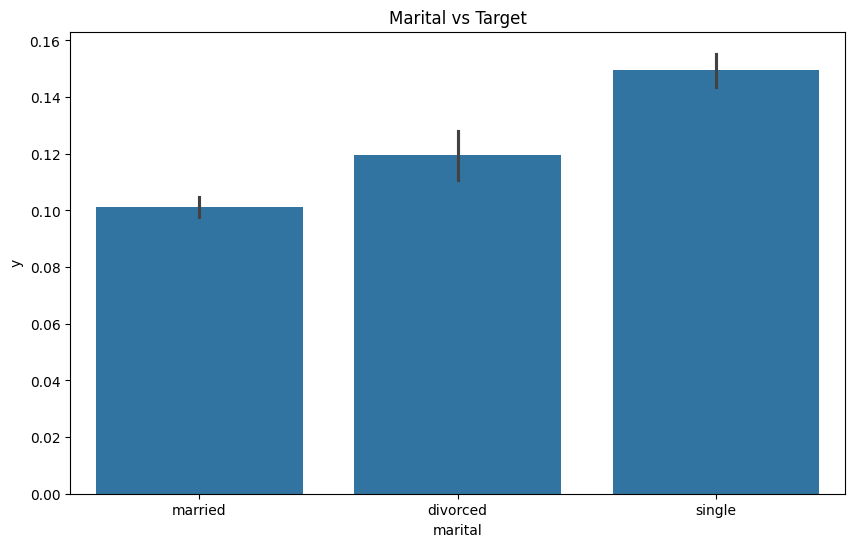

In [39]:
# Marital
plt.figure(figsize=(10,6))
sns.barplot(x='marital',y='y',data=data,order=data.groupby('marital')['y'].mean().reset_index().sort_values('y')['marital'])
plt.xticks(rotation=0)
plt.title('Marital vs Target')
plt.show()

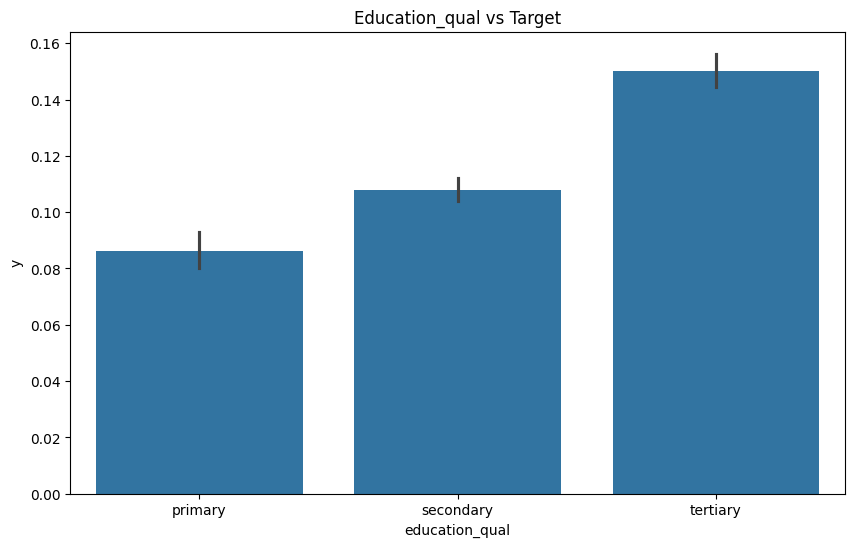

In [40]:
# Education_qual
plt.figure(figsize=(10,6))
sns.barplot(x='education_qual',y='y',data=data,order=data.groupby('education_qual')['y'].mean().reset_index().sort_values('y')['education_qual'])
plt.xticks(rotation=0)
plt.title('Education_qual vs Target')
plt.show()

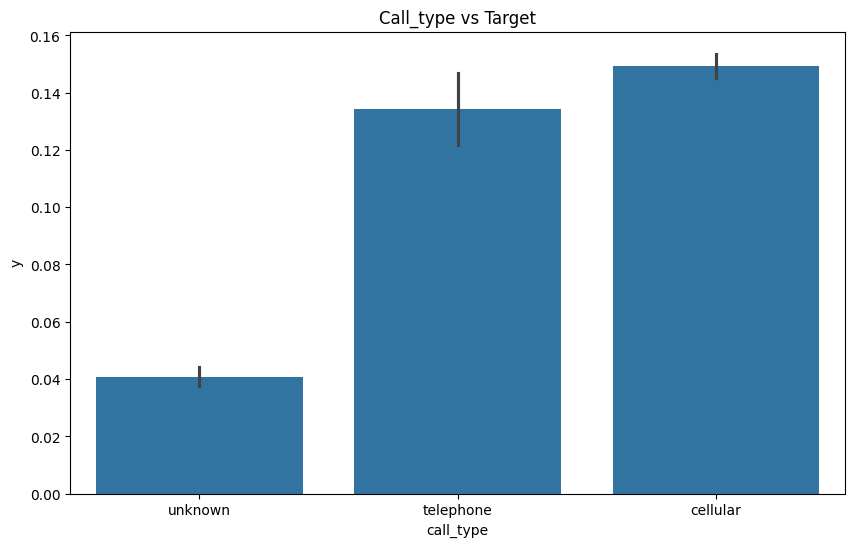

In [41]:
# Call_type
plt.figure(figsize=(10,6))
sns.barplot(x='call_type',y='y',data=data,order=data.groupby('call_type')['y'].mean().reset_index().sort_values('y')['call_type'])
plt.xticks(rotation=0)
plt.title('Call_type vs Target')
plt.show()

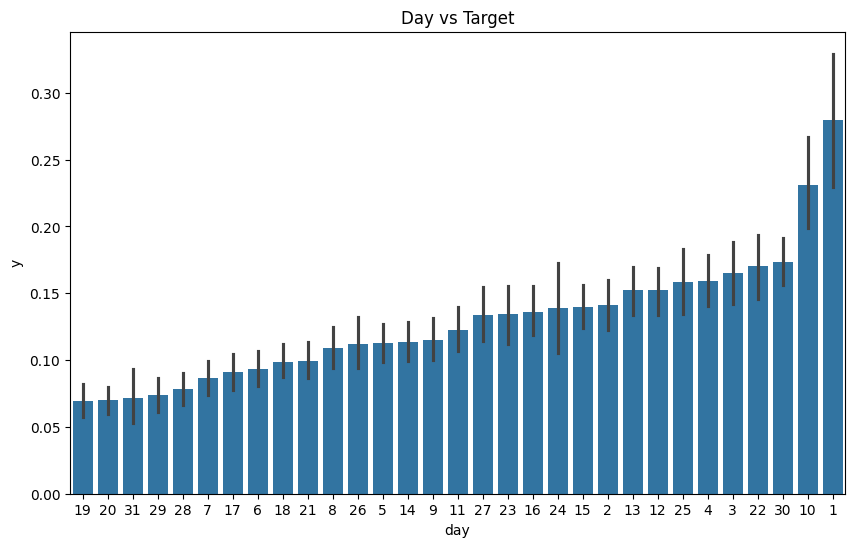

In [42]:
# DAY
plt.figure(figsize=(10,6))
sns.barplot(x='day',y='y',data=data,order=data.groupby('day')['y'].mean().reset_index().sort_values('y')['day'])
plt.xticks(rotation=0)
plt.title('Day vs Target')
plt.show()

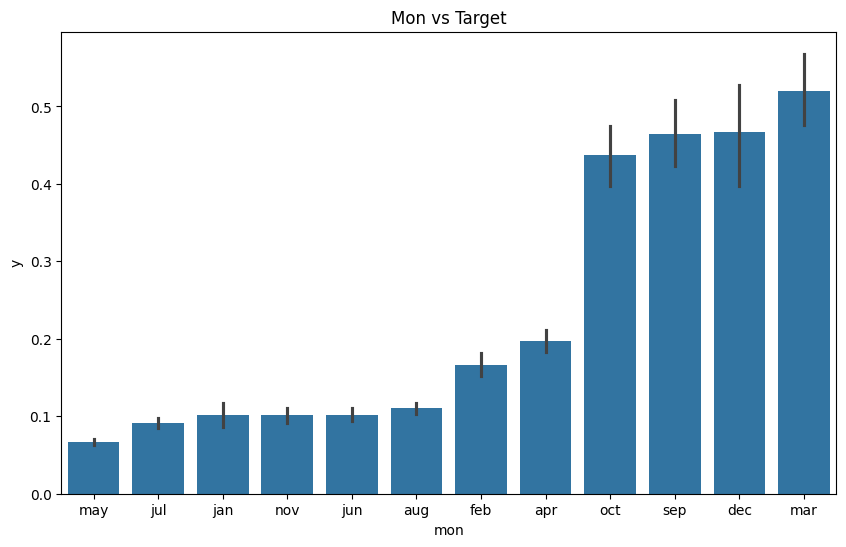

In [43]:
# Month(mon)
plt.figure(figsize=(10,6))
sns.barplot(x='mon',y='y',data=data,order=data.groupby('mon')['y'].mean().reset_index().sort_values('y')['mon'])
plt.xticks(rotation=0)
plt.title('Mon vs Target')
plt.show()

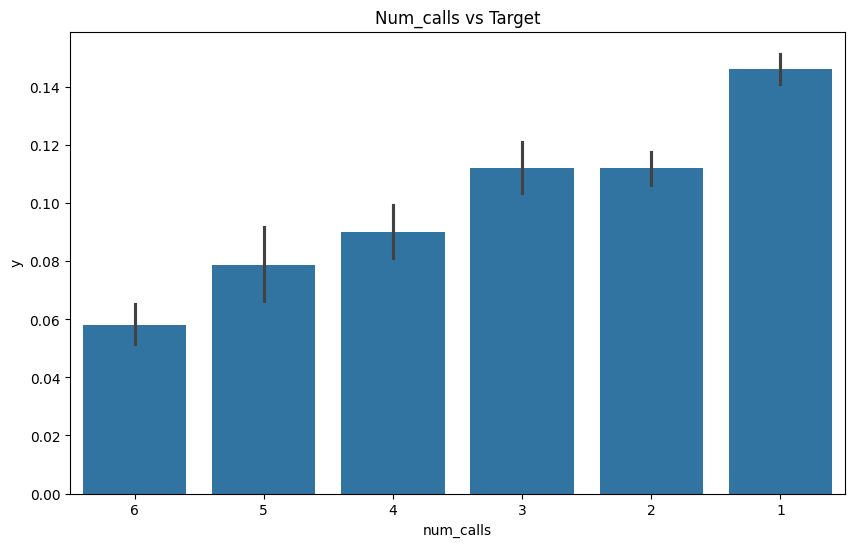

In [44]:
# Num_calls
plt.figure(figsize=(10,6))
sns.barplot(x='num_calls',y='y',data=data,order=data.groupby('num_calls')['y'].mean().reset_index().sort_values('y')['num_calls'])
plt.xticks(rotation=0)
plt.title('Num_calls vs Target')
plt.show()

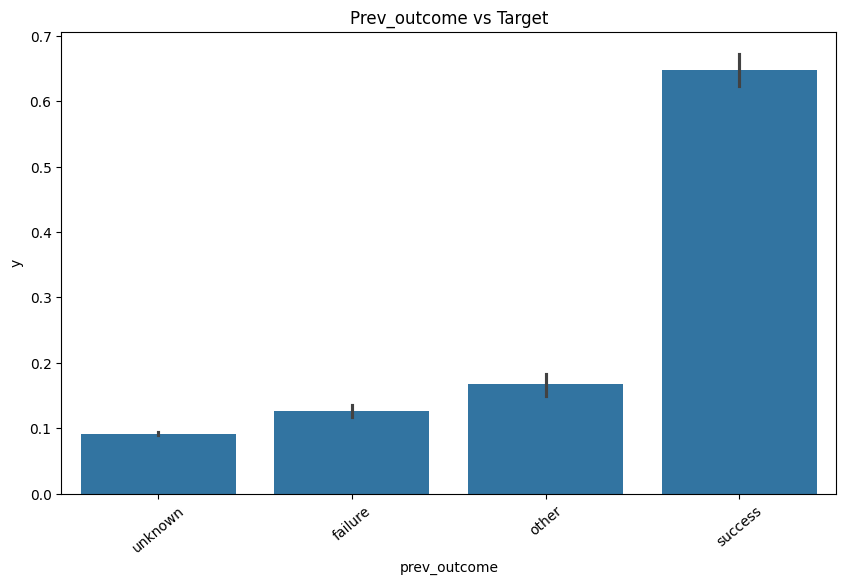

In [45]:
# Prev_outcome
plt.figure(figsize=(10,6))
sns.barplot(x='prev_outcome',y='y',data=data,order=data.groupby('prev_outcome')['y'].mean().reset_index().sort_values('y')['prev_outcome'])
plt.xticks(rotation=40)
plt.title('Prev_outcome vs Target')
plt.show()

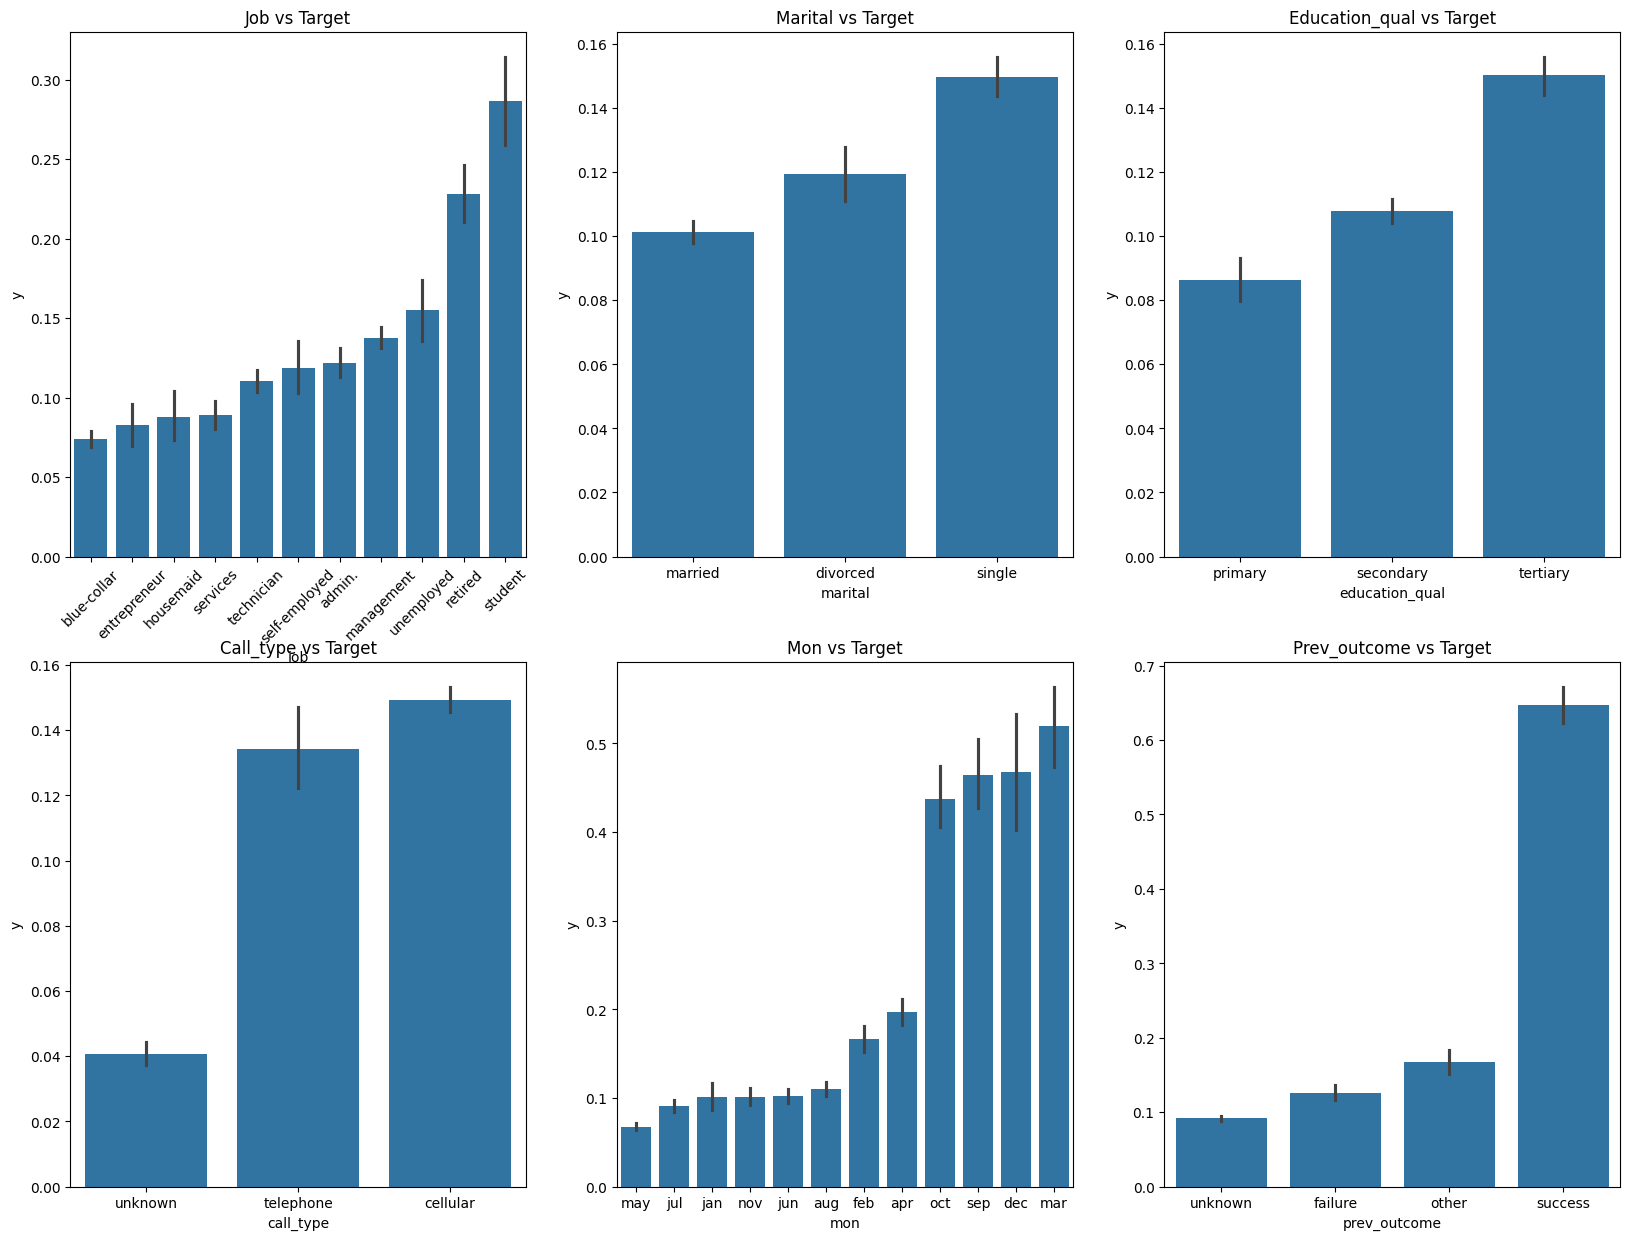

<Figure size 640x480 with 0 Axes>

In [46]:
# Feature Vs Target plots together(for reference)
plt.figure(figsize=(20,15))

plt.subplot(231)
sns.barplot(x='job',y='y',data=data,order=data.groupby('job')['y'].mean().reset_index().sort_values('y')['job'])
plt.xticks(rotation=45)
plt.title('Job vs Target')


plt.subplot(232)
sns.barplot(x='marital',y='y',data=data,order=data.groupby('marital')['y'].mean().reset_index().sort_values('y')['marital'])
plt.xticks(rotation=0)
plt.title('Marital vs Target')


plt.subplot(233)
sns.barplot(x='education_qual',y='y',data=data,order=data.groupby('education_qual')['y'].mean().reset_index().sort_values('y')['education_qual'])
plt.xticks(rotation=0)
plt.title('Education_qual vs Target')


plt.subplot(234)
sns.barplot(x='call_type',y='y',data=data,order=data.groupby('call_type')['y'].mean().reset_index().sort_values('y')['call_type'])
plt.xticks(rotation=0)
plt.title('Call_type vs Target')


plt.subplot(235)
sns.barplot(x='mon',y='y',data=data,order=data.groupby('mon')['y'].mean().reset_index().sort_values('y')['mon'])
plt.xticks(rotation=0)
plt.title('Mon vs Target')


plt.subplot(236)
sns.barplot(x='prev_outcome',y='y',data=data,order=data.groupby('prev_outcome')['y'].mean().reset_index().sort_values('y')['prev_outcome'])
plt.xticks(rotation=0)
plt.title('Prev_outcome vs Target')

plt.show()
plt.tight_layout()

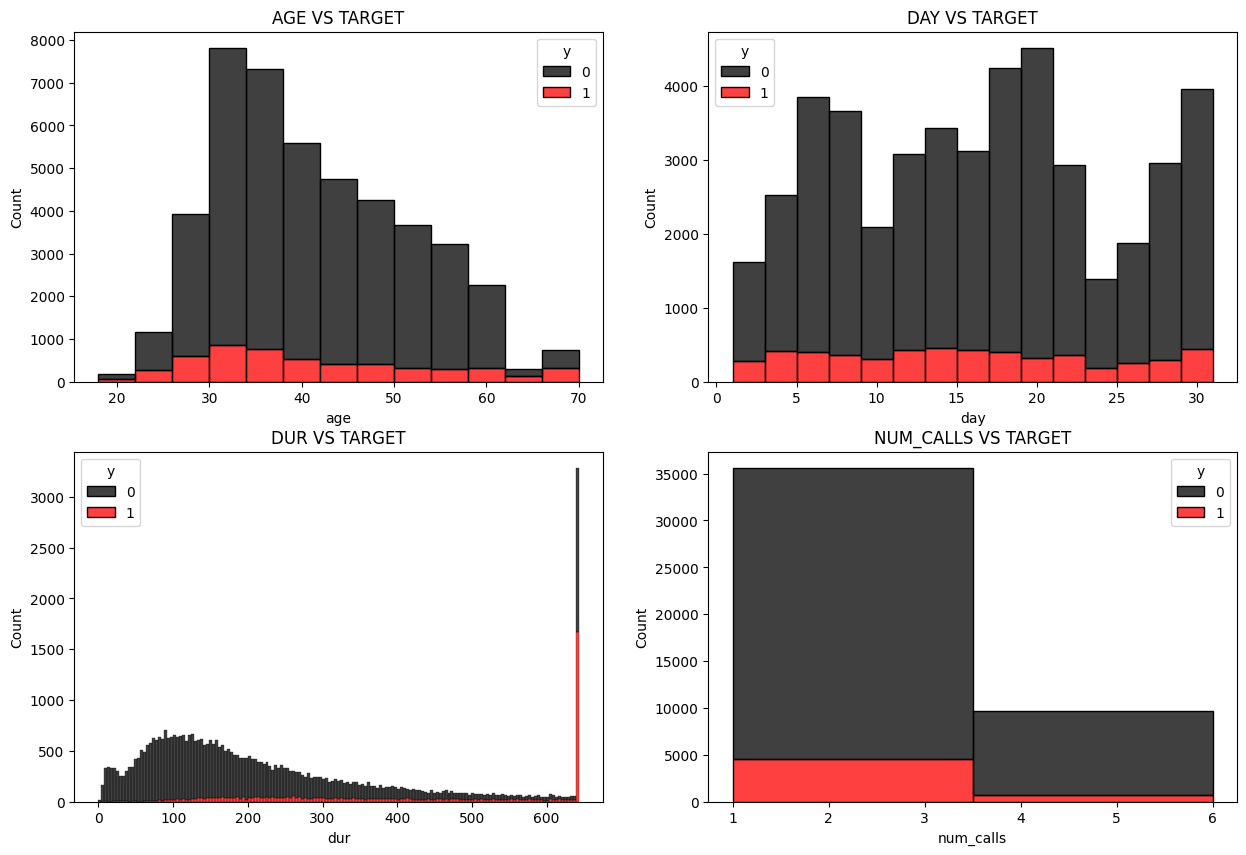

<Figure size 640x480 with 0 Axes>

In [47]:
plt.figure(figsize=(15,10))

plt.subplot(221)
sns.histplot(data=data, x="age", hue="y", multiple="stack", binwidth=4,palette=["black","red"])
plt.title('AGE VS TARGET')

plt.subplot(222)
sns.histplot(data=data, x="day", hue="y", multiple="stack", binwidth=2,palette=["black","red"])
plt.title('DAY VS TARGET')

plt.subplot(223)
sns.histplot(data=data, x="dur", hue="y", multiple="stack", binwidth=4,palette=["black","red"])
plt.title('DUR VS TARGET')

plt.subplot(224)
sns.histplot(data=data, x="num_calls", hue="y", multiple="stack", binwidth=3,palette=["black","red"])
plt.title('NUM_CALLS VS TARGET')

plt.show()
plt.tight_layout()

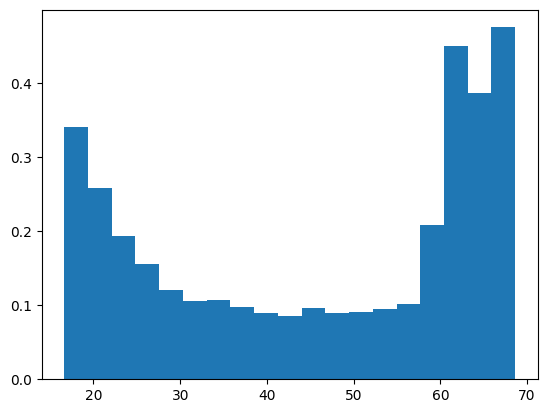

In [48]:
bins=np.linspace(data.age.min(),data.age.max(),20)
c=np.digitize(data.age,bins)
plt.bar(bins[:-1], [np.mean(data.y.values[c == i]) for i in range(1, len(bins))], width = bins[1] - bins[0])
plt.show()

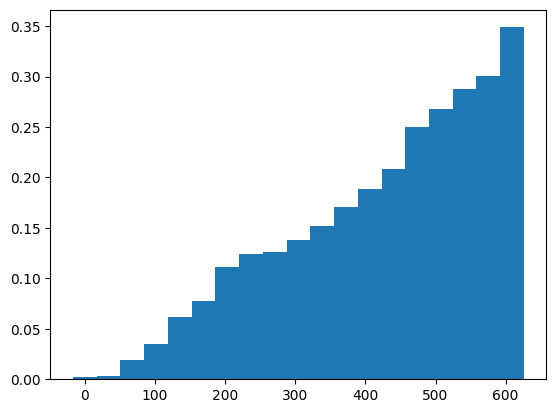

In [49]:
bins=np.linspace(data.dur.min(),data.dur.max(),20)
c=np.digitize(data.dur,bins)
plt.bar(bins[:-1], [np.mean(data.y.values[c == i]) for i in range(1, len(bins))], width = bins[1] - bins[0])
plt.show()

In [50]:
# Feature analysis

# plt.figure(figsize=10, 8))
# sns.scatterplot(x='age', y='num_calls', hue='y', data=data, s=150)
# plt.title("Age vs Num_calls vs Target", y=1.020, fontsize=20)
# plt.xlabel("age", Labelpad=12)
# plt.ylabel("num_calls", Labelpad=12)
# ax = plt.gca()

In [51]:
# plt.figure(figsize=10, 8))
# sns.scatterplot(x='dur', y='num_calls', hue='y', data=data, s=150)
# plt.title("Dur vs Num_calls vs Target", y=1.020, fontsize=20)
# plt.xlabel("dur", Labelpad=12)
# plt.ylabel("num_calls", Labelpad=12)
# ax = plt.gca()

In [52]:
# Encoding the data
data.dtypes

,0
age,int64
job,object
marital,object
education_qual,object
call_type,object
day,int64
mon,object
dur,int64
num_calls,int64
prev_outcome,object


In [53]:
# Label Encoding

data['job'] = data['job'].map({'blue-collar':0, 'entrepreneur':1, 'housemaid':2, 'services':3, 'technician':4, 'self-employed':5, 'admin':6, 'management':7, 'unemployed':8, 'retired':9, 'student':10})
data['education_qual'] = data['education_qual'].map({'primary':0, 'secondary':1, 'tertiary':2})
data['marital'] = data['marital'].map({'married':0, 'divorced':1, 'single':2})
data['mon'] = data['mon'].map({'may':0, 'jul':1, 'jan':2, 'nov':3, 'jun':4, 'aug':5, 'feb':6, 'apr':7, 'oct':8, 'sep':9, 'dec':10, 'mar':11})
data['call_type'] = data['call_type'].map({'unknown':0, 'telephone':1, 'cellular':2})
data['prev_outcome'] = data['prev_outcome'].map({'unknown':0, 'failure':1, 'other':2, 'success':3})

data.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,7.0,0,2,0,5,0,261,1,0,0
1,44,4.0,2,1,0,5,0,151,1,0,0
2,33,1.0,0,1,0,5,0,76,1,0,0
3,47,0.0,0,1,0,5,0,92,1,0,0
4,33,0.0,2,1,0,5,0,198,1,0,0


In [54]:
data.isnull().sum()

,0
age,0
job,5170
marital,0
education_qual,0
call_type,0
day,0
mon,0
dur,0
num_calls,0
prev_outcome,0


In [55]:
data['job'] = data['job'].fillna(data['job'].mean())

In [56]:
data.isnull().sum()

,0
age,0
job,0
marital,0
education_qual,0
call_type,0
day,0
mon,0
dur,0
num_calls,0
prev_outcome,0


In [57]:
# Target vs Feature
X = data[['age','job','marital','education_qual','day','dur','num_calls']]

y = data['y'].values

In [58]:
# Splitting the Data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=0, stratify=y)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36164, 7), (9041, 7), (36164,), (9041,))

In [60]:
print("Shape of X_train:",X_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of X_test:",y_test.shape)

Shape of X_train: (36164, 7)
Shape of X_test: (9041, 7)
Shape of y_train: (36164,)
Shape of X_test: (9041,)


In [61]:
# Balancing the data using SMOTEENN
smt = SMOTEENN(sampling_strategy='all')
X_train, y_train = smt.fit_resample(X_train, y_train)

In [62]:
# Checking whether it is balanced or not
print(len(X_train))
print(len(y_train))

51147
51147


In [63]:
# Scaling the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [64]:
# Modelling
# Logistic Regression
Lr = LogisticRegression()
Lr.fit(X_train,y_train)
Lr.score(X_train,y_train)
y_pred = Lr.predict(X_test)
print("Training Accuracy :",Lr.score(X_train,y_train))
print("Testing Accuracy :",Lr.score(X_test,y_test))
print("F1 Score :", f1_score(y_test,y_pred))
# print("ROC AUC Score :", roc_auc_score(y_test,y_pred))

Training Accuracy : 0.8398733063522787
Testing Accuracy : 0.7019135051432364
F1 Score : 0.3771666281488329


In [65]:
print("Precision: {0}".format(precision_score(y_test, Lr.predict(X_test))))

Precision: 0.24961762006729887


In [66]:
print("Recall:", round(recall_score(y_test, Lr.predict(X_test)), 2))

Recall: 0.77


In [67]:
# Decision Tree
for depth in [1,2,3,4,5,6,7,8,9,10,20,40,60]:
  dt = DecisionTreeClassifier(max_depth=depth) # This will stop the tree when it reaches the max depth
  dt.fit(X_train, y_train)
  trainAccuracy = accuracy_score(y_train, dt.predict(X_train))
  dt = DecisionTreeClassifier(max_depth=depth)
  valAccuracy = cross_val_score(dt, X_train, y_train, cv=10)
  dt = DecisionTreeClassifier(max_depth=depth)
  dt.fit(X_train,y_train)
  y_pred = dt.predict(X_test)
  roc = roc_auc_score(y_test,y_pred)

  print("Depth : ", depth, "Training Accuracy : ", trainAccuracy, "Cross val score : ",np.mean(valAccuracy))

Depth :  1 Training Accuracy :  0.8023735507458893 Cross val score :  0.8021386331046088
Depth :  2 Training Accuracy :  0.8023735507458893 Cross val score :  0.8021386331046088
Depth :  3 Training Accuracy :  0.8481240346452382 Cross val score :  0.8479677851343237
Depth :  4 Training Accuracy :  0.8532856277005494 Cross val score :  0.8520344589115958
Depth :  5 Training Accuracy :  0.8591119713766203 Cross val score :  0.8571571340589974
Depth :  6 Training Accuracy :  0.8738342424775647 Cross val score :  0.8684775964318522
Depth :  7 Training Accuracy :  0.8830234422351262 Cross val score :  0.8777254969873589
Depth :  8 Training Accuracy :  0.8947347840538057 Cross val score :  0.8863085903377577
Depth :  9 Training Accuracy :  0.9045887344321271 Cross val score :  0.8933471875452776
Depth :  10 Training Accuracy :  0.9164564881615735 Cross val score :  0.9000143282523088
Depth :  20 Training Accuracy :  0.9952685396992981 Cross val score :  0.9335650396760314
Depth :  40 Trainin

In [68]:
t = DecisionTreeClassifier(max_depth=40)
t.fit(X_train,y_train)
y_pred = t.predict(X_test)
print("Training Accuracy :",t.score(X_train,y_train))
print("Testing Accuracy :",t.score(X_test,y_test))
print("F1 Score :", f1_score(y_test,y_pred))
# print("ROC AUC Score :", roc_auc_score(y_test,y_pred))

Training Accuracy : 1.0
Testing Accuracy : 0.7833204291560668
F1 Score : 0.39518369867242975


In [69]:
# Feature Importance
data.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y'],
      dtype='object')

In [70]:
X_test = pd.DataFrame(X_test, columns = ['age','job','marital','education_qual','day','dur','num_calls'])

dtc = DecisionTreeClassifier(max_depth=40)
dtc.fit(X_train, y_train)

importance = dtc.feature_importances_

feature_importances = list(zip(X_test.columns, importance))

feature_importances.sort(key=lambda x: x[1], reverse=True)

for feature, importance in feature_importances:
  print(feature, " : ", importance)

dur  :  0.5484865101338889
job  :  0.231564501039316
age  :  0.0807042567258038
day  :  0.06886550325785665
num_calls  :  0.04392161350053916
education_qual  :  0.013422913156952616
marital  :  0.013034702185642892


In [71]:
# K-Nearest Neighbour
for i in [1,2,3,4,5,6,7,8,9,10,20,40,50]:
  knn= KNeighborsClassifier(i)
  knn.fit(X_train, y_train)

  print("Kvalue : ", i, "Train score : ", knn.score(X_train,y_train), "Cross val score : ", np.mean(cross_val_score(knn, X_train, y_train, cv=10)))

Kvalue :  1 Train score :  1.0 Cross val score :  0.9908499467278027
Kvalue :  2 Train score :  0.9994916612900072 Cross val score :  0.9927268789679378
Kvalue :  3 Train score :  0.9948579584335348 Cross val score :  0.9799988607739627
Kvalue :  4 Train score :  0.9957182239427532 Cross val score :  0.9823450318084908
Kvalue :  5 Train score :  0.9866072301405752 Cross val score :  0.9673295203667237
Kvalue :  6 Train score :  0.9877216650047901 Cross val score :  0.9698125590877934
Kvalue :  7 Train score :  0.9757170508534225 Cross val score :  0.9563611782349717
Kvalue :  8 Train score :  0.9771052065614797 Cross val score :  0.9581794976777758
Kvalue :  9 Train score :  0.9651396953878038 Cross val score :  0.9470937158686159
Kvalue :  10 Train score :  0.9667233659843197 Cross val score :  0.9488534683889622
Kvalue :  20 Train score :  0.9336226953682523 Cross val score :  0.9197998173415434
Kvalue :  40 Train score :  0.9024185191702349 Cross val score :  0.8915478641232107
Kval

In [72]:
knn = KNeighborsClassifier(1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Training Accuracy :",knn.score(X_train,y_train))
print("Testing Accuracy :",knn.score(X_test,y_test))
print("F1 Score :", f1_score(y_test,y_pred))

# print("ROC AUC Score :", roc_auc_score(y_test,y_pred))

Training Accuracy : 1.0
Testing Accuracy : 0.7436124322530694
F1 Score : 0.37688172043010754


In [73]:
knn.score(X_test,y_test)

0.7436124322530694

In [74]:
X_test.shape

(9041, 7)

In [75]:
# XG-Boost
for i in[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
    model = xgb.XGBClassifier(learning_rate = i, n_estimators=100, verbosity = 0)
    model.fit(X_train, y_train)
    model.score(X_test, y_test)

    print("Learning rate : ", i, " Train score : ", model.score(X_train,y_train), " Cross val score : ", np.mean(cross_val_score(model, X_train, y_train, cv=10)))

Learning rate :  0.01  Train score :  0.8877940055135198  Cross val score :  0.8825153766843247
Learning rate :  0.02  Train score :  0.8974719924922283  Cross val score :  0.8930536992160366
Learning rate :  0.03  Train score :  0.9045691829432811  Cross val score :  0.8990952175061576
Learning rate :  0.04  Train score :  0.9103759751305062  Cross val score :  0.9042373397772241
Learning rate :  0.05  Train score :  0.9178250923807848  Cross val score :  0.9103960913078201
Learning rate :  0.06  Train score :  0.9235536786126264  Cross val score :  0.9166331206650632
Learning rate :  0.07  Train score :  0.9264277474729701  Cross val score :  0.9191944869105605
Learning rate :  0.08  Train score :  0.929438676755235  Cross val score :  0.9216579255917189
Learning rate :  0.09  Train score :  0.9317653039278941  Cross val score :  0.9234763100239276
Learning rate :  0.1  Train score :  0.934131034078245  Cross val score :  0.9245712820995096
Learning rate :  0.11  Train score :  0.935

In [76]:
xg = XGBClassifier(learning_rate = 1, n_estimators=100, verbosity = 0)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
print("Training Accuracy :",xg.score(X_train,y_train))
print("Testing Accuracy :",xg.score(X_test,y_test))
print("F1 Score :", f1_score(y_test,y_pred))
# print("ROC AUC Score :", roc_auc_score(y_test, y_pred))

Training Accuracy : 0.9907912487535926
Testing Accuracy : 0.7961508682667846
F1 Score : 0.4271059993783028


In [77]:
# Random Forest
random = RandomForestClassifier(max_depth=2,n_estimators=100,max_features="sqrt")
random.fit(X_train,y_train)
y_pred = random.predict(X_test)

In [78]:
for depth in [1,2,3,4,5,6,7,8,9,10]:
    random = RandomForestClassifier(max_depth=2,n_estimators=100,max_features="sqrt")
    random.fit(X_train,y_train)
    random = RandomForestClassifier(max_depth=2,n_estimators=100,max_features="sqrt")
    valAccuracy = cross_val_score(random, X_train, y_train, cv=10)

    print("Depth : ", depth, "Training Accuracy :", trainAccuracy, "Cross val score : ",np.mean(valAccuracy))

Depth :  1 Training Accuracy : 1.0 Cross val score :  0.832697874578859
Depth :  2 Training Accuracy : 1.0 Cross val score :  0.832306860090427
Depth :  3 Training Accuracy : 1.0 Cross val score :  0.8304691585133636
Depth :  4 Training Accuracy : 1.0 Cross val score :  0.8295304018524273
Depth :  5 Training Accuracy : 1.0 Cross val score :  0.8290810765762512
Depth :  6 Training Accuracy : 1.0 Cross val score :  0.830195438431905
Depth :  7 Training Accuracy : 1.0 Cross val score :  0.8271257594680961
Depth :  8 Training Accuracy : 1.0 Cross val score :  0.8319940584392373
Depth :  9 Training Accuracy : 1.0 Cross val score :  0.8285333764557148
Depth :  10 Training Accuracy : 1.0 Cross val score :  0.8280642217652575


In [79]:
random = RandomForestClassifier(n_estimators=100,max_depth = 3, max_features="sqrt")
random.fit(X_train,y_train)
predictions = random.predict(X_test)
print("Training Accuracy :",random.score(X_train,y_train))
print("Testing Accuracy :",random.score(X_test,y_test))
print("F1 Score :", f1_score(y_test,predictions))
# print("ROC AUC Score :", roc_auc_score(y_test,predictions))

Training Accuracy : 0.8459929223610378
Testing Accuracy : 0.6479371750912509
F1 Score : 0.35994369595817416
